# Task 1 — Data Extraction, Cleaning, EDA, Stationarity, and Risk Metrics

Assets:
- TSLA (high risk / high growth)
- BND (low risk bonds ETF)
- SPY (broad market, moderate risk)

Period: 2015-01-01 to 2026-01-15  
Risk-free rate assumption for Sharpe Ratio: **2% annual**.

In [2]:
from __future__ import annotations

# Ensure the project root is on sys.path so `import src...` works when running from notebooks/
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import (
    TICKERS, START_DATE, END_DATE,
    PRICE_COL, PRICES_PATH, RETURNS_PATH,
    TASK1_ADF_PATH, TASK1_RISK_PATH, TASK1_OUTLIERS_PATH,
    DEFAULT_VAR_LEVEL, RISK_FREE_RATE_ANNUAL, ANNUALIZATION_FACTOR
)
from src.data_fetch import fetch_yfinance_prices
from src.data_prep import clean_prices, add_daily_returns
from src.stationarity import adf_test
from src.risk_metrics import historical_var, sharpe_ratio, annualized_vol
from src.eda import rolling_volatility, detect_outliers_zscore, summary_stats

from src.io import save_parquet, load_parquet, save_csv

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

## 1) Extract historical financial data (YFinance)
We fetch TSLA, BND, SPY OHLCV data and store it in a tidy format.

In [4]:
prices_raw = fetch_yfinance_prices(TICKERS, START_DATE, END_DATE)
prices_raw.head(), prices_raw.shape

(Price       date asset        open        high         low       close  \
 0     2015-01-02   BND   82.430000   82.690002   82.419998   82.650002   
 1     2015-01-02   SPY  206.380005  206.880005  204.179993  205.429993   
 2     2015-01-02  TSLA   14.858000   14.883333   14.217333   14.620667   
 3     2015-01-05   BND   82.739998   82.919998   82.699997   82.889999   
 4     2015-01-05   SPY  204.169998  204.369995  201.350006  201.720001   
 
 Price   adj_close     volume  
 0       60.385979    2218800  
 1      170.589630  121465900  
 2       14.620667   71466000  
 3       60.561329    5820100  
 4      167.508789  169632600  ,
 (8325, 8))

In [5]:
(prices_raw.groupby("asset")["date"]
 .agg(["min", "max", "count"])
 .sort_index())

,min,max,count
asset,,,
BND,2015-01-02,2026-01-14,2775
SPY,2015-01-02,2026-01-14,2775
TSLA,2015-01-02,2026-01-14,2775


## 2) Data cleaning & understanding
We ensure correct dtypes, handle missing values, remove duplicates, and create a cleaned dataset.

In [6]:
prices = clean_prices(prices_raw)
prices.isna().sum()

Price
date         0
asset        0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [7]:
(prices.groupby("asset")["date"]
 .agg(["min", "max", "count"])
 .sort_index())

,min,max,count
asset,,,
BND,2015-01-02,2026-01-14,2775
SPY,2015-01-02,2026-01-14,2775
TSLA,2015-01-02,2026-01-14,2775


In [8]:
save_parquet(prices, PRICES_PATH)
PRICES_PATH

'data/processed/prices.parquet'

### Basic statistics (per asset)

In [9]:
stats = summary_stats(prices)
stats.head(20)

asset,Price,stat,BND,SPY,TSLA
0,open,count,2775.000000,2775.000000,2775.000000
1,open,mean,79.558094,361.798717,138.505925
2,open,std,5.296254,133.244618,131.791350
3,open,min,68.080002,182.339996,9.488000
4,open,25%,74.019997,248.134995,17.836666
5,open,50%,81.010002,327.350006,93.066666
6,open,75%,83.584999,444.174988,242.901665
7,open,max,89.550003,695.489990,489.880005
8,high,count,2775.000000,2775.000000,2775.000000
9,high,mean,79.670032,363.747308,141.534064


## 3) Compute daily returns (Adj Close)
We compute daily percentage returns from adjusted close.

In [10]:
prices_ret = add_daily_returns(prices, price_col=PRICE_COL)
prices_ret.head()

Price,date,asset,open,high,low,close,adj_close,volume,return
0,2015-01-02,BND,82.430000,82.690002,82.419998,82.650002,60.385979,2218800,NaN
3,2015-01-05,BND,82.739998,82.919998,82.699997,82.889999,60.561329,5820100,0.002904
6,2015-01-06,BND,83.029999,83.379997,83.029999,83.129997,60.736687,3887600,0.002896
9,2015-01-07,BND,83.139999,83.279999,83.050003,83.180000,60.773174,2433400,0.000601
12,2015-01-08,BND,83.110001,83.110001,82.970001,83.050003,60.678234,1873400,-0.001562


In [11]:
save_parquet(prices_ret, RETURNS_PATH)
RETURNS_PATH

'data/processed/returns.parquet'

# EDA Visualization 1 — Adjusted Close over time

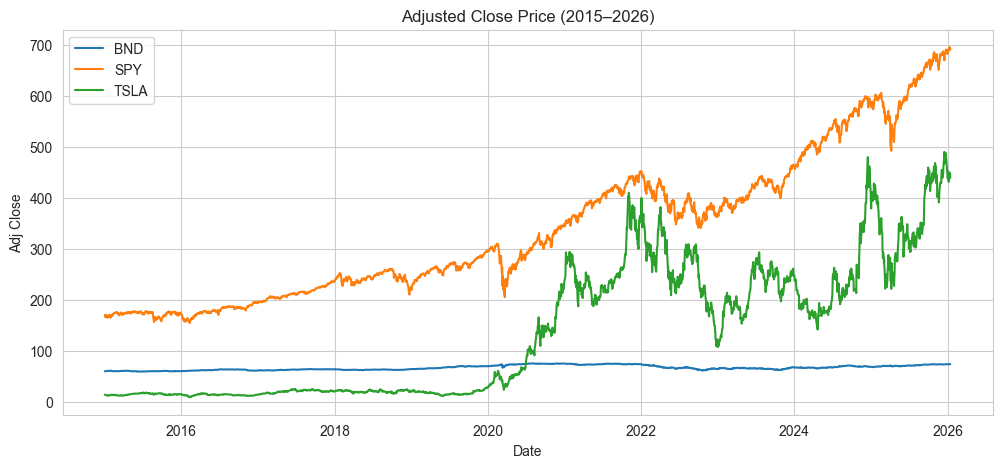

In [12]:
for asset, g in prices_ret.groupby("asset"):
    plt.plot(g["date"], g[PRICE_COL], label=asset)
plt.title("Adjusted Close Price (2015–2026)")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.legend()
plt.show()

## EDA Visualization 2 — Daily returns over time

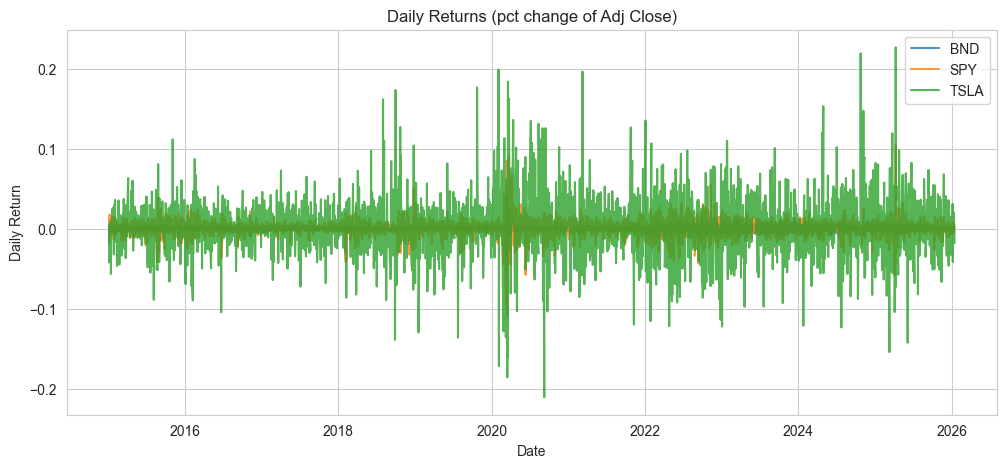

In [13]:
for asset, g in prices_ret.groupby("asset"):
    plt.plot(g["date"], g["return"], label=asset, alpha=0.8)
plt.title("Daily Returns (pct change of Adj Close)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

## EDA Visualization 3 — Rolling volatility (20-day)

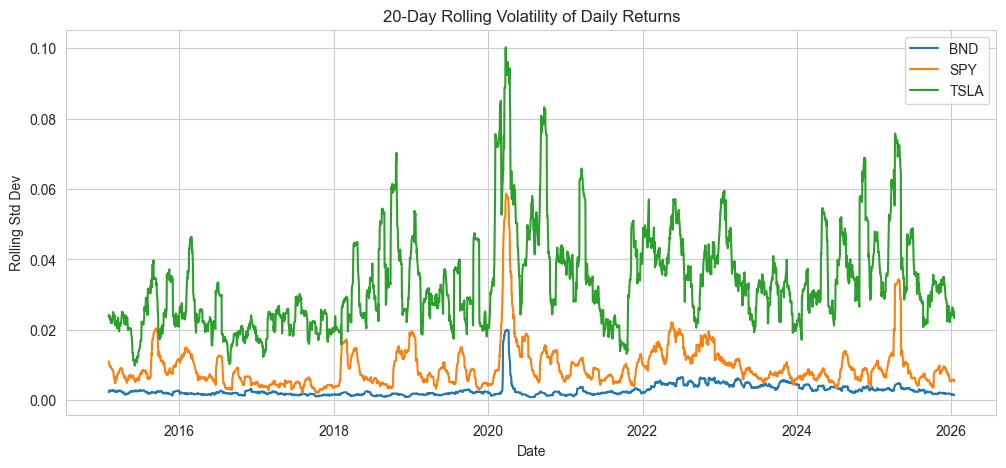

In [14]:
window = 20
for asset, g in prices_ret.groupby("asset"):
    rv = rolling_volatility(g["return"], window=window)
    plt.plot(g["date"], rv, label=asset)
plt.title(f"{window}-Day Rolling Volatility of Daily Returns")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.show()

## 4) Outlier detection (extreme daily returns)
We flag days where |z-score| ≥ 3 within each asset.

In [15]:
outliers = detect_outliers_zscore(prices_ret, return_col="return", z=3.0)
outliers.sort_values(["asset", "zscore"]).head(10), outliers.shape

(Price       date asset    return     zscore
 3918  2020-03-12   BND -0.054386 -16.143883
 3930  2020-03-18   BND -0.024140  -7.179112
 3927  2020-03-17   BND -0.020686  -6.155221
 3915  2020-03-11   BND -0.018939  -5.637623
 5622  2022-06-13   BND -0.016153  -4.811656
 3912  2020-03-10   BND -0.013444  -4.008954
 5838  2022-09-26   BND -0.012778  -3.811354
 5409  2022-03-02   BND -0.012284  -3.665089
 7740  2025-04-07   BND -0.012056  -3.597483
 6996  2024-04-10   BND -0.011686  -3.487742,
 (115, 4))

In [16]:
save_csv(outliers, TASK1_OUTLIERS_PATH)
TASK1_OUTLIERS_PATH

'data/processed/task1_outliers.csv'

## 5) Stationarity testing (ADF)
ADF test is applied to:
- Price series (Adj Close): often non-stationary
- Return series: often closer to stationary

In [17]:
rows = []
for asset, g in prices_ret.groupby("asset"):
    g = g.sort_values("date")
    res_price = adf_test(g[PRICE_COL])
    res_ret = adf_test(g["return"].dropna())

    rows.append({"asset": asset, "series": PRICE_COL, **res_price})
    rows.append({"asset": asset, "series": "return", **res_ret})

adf_results = pd.DataFrame(rows)
adf_results

,asset,series,test_stat,p_value,used_lag,n_obs,critical_values,is_stationary_5pct
0,BND,adj_close,-1.051379,7.340672e-01,13,2761,"{'1%': -3.43272065921814, '5%': -2.86258738817...",False
1,BND,return,-10.433745,1.585997e-18,23,2750,"{'1%': -3.432730150728559, '5%': -2.8625915799...",True
2,SPY,adj_close,1.170881,9.957784e-01,9,2765,"{'1%': -3.432717226501251, '5%': -2.8625858721...",False
3,SPY,return,-17.228844,6.211464e-30,8,2765,"{'1%': -3.432717226501251, '5%': -2.8625858721...",True
4,TSLA,adj_close,-0.780157,8.248814e-01,28,2746,"{'1%': -3.4327336210581345, '5%': -2.862593112...",False
5,TSLA,return,-53.019619,0.000000e+00,0,2773,"{'1%': -3.4327103908048398, '5%': -2.862582853...",True


In [18]:
adf_export = adf_results.copy()
adf_export["crit_1pct"] = adf_export["critical_values"].apply(
    lambda d: d["1%"])
adf_export["crit_5pct"] = adf_export["critical_values"].apply(
    lambda d: d["5%"])
adf_export["crit_10pct"] = adf_export["critical_values"].apply(
    lambda d: d["10%"])
adf_export = adf_export.drop(columns=["critical_values"])

save_csv(adf_export, TASK1_ADF_PATH)
TASK1_ADF_PATH

'data/processed/task1_adf_results.csv'

### Interpretation (to complete)
- If p-value > 0.05 for prices, we fail to reject the unit-root hypothesis → non-stationary prices.
- If p-value < 0.05 for returns, we reject the unit-root hypothesis → (more) stationary returns.
- Implication for ARIMA: price series usually requires differencing (d ≥ 1).


## 6) Risk metrics (VaR, Sharpe)
We compute:
- Historical VaR at 95% confidence (loss threshold)
- Annualized volatility
- Sharpe ratio using risk-free rate = 2% annual


In [19]:
risk_rows = []
for asset, g in prices_ret.groupby("asset"):
    r = g["return"]
    risk_rows.append({
        "asset": asset,
        "VaR_95": historical_var(r, level=DEFAULT_VAR_LEVEL),
        "ann_vol": annualized_vol(r, annualization_factor=ANNUALIZATION_FACTOR),
        "sharpe_rf_annual": RISK_FREE_RATE_ANNUAL,
        "sharpe": sharpe_ratio(r, rf_annual=RISK_FREE_RATE_ANNUAL, annualization_factor=ANNUALIZATION_FACTOR),
    })

risk_table = pd.DataFrame(risk_rows).sort_values("asset")
risk_table

,asset,VaR_95,ann_vol,sharpe_rf_annual,sharpe
0,BND,0.004797,0.053568,0.02,0.008097
1,SPY,0.016719,0.177676,0.02,0.691427
2,TSLA,0.052529,0.576923,0.02,0.788518


In [20]:
save_csv(risk_table, TASK1_RISK_PATH)
TASK1_RISK_PATH

'data/processed/task1_risk_metrics.csv'

## Data Quality Summary (to complete)
- Missing values: 0 (0%) across all cleaned fields ( date, asset, open, high, low, close, adj_close, volume).
- Handling method: Missing prices were forward-filled within each asset; missing volume set to 0; any remaining missing rows dropped. Final cleaned outputs contain no missing values.
- Duplicates: Duplicates defined on (asset, date)were removed (kept last), ensuring one record per asset per trading day.
- Coverage/consistency: All assets have aligned coverage from 2015-01-02 to 2026-01-14 with 2775 observations each.
- Notes/limitations: yfinance-sourced OHLCV/adjusted prices may contain provider revisions/anomalies; adjusted prices reflect corporate actions where applicable. Data is on trading days only; holidays and differing trading calendars can affect alignment when expanding the universe.
